# Stable Diffusion with Diffusers

- Stable diffusion - open source text to image model
- Hugging Face [diffusers library](https://github.com/huggingface/diffusers)
- Explore diffusion models and examine main components

Install libraries

In [1]:
!pip install -Uq diffusers transformers fastcore

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
allennlp 2.10.1 requires transformers<4.21,>=4.1, but you have transformers 4.25.1 which is incompatible.


Import modules and login to with Hugging Face token

In [2]:
import logging
from pathlib import Path

import matplotlib.pyplot as plt
import torch
from diffusers import StableDiffusionPipeline
from fastcore.all import concat
from huggingface_hub import notebook_login
from PIL import Image

logging.disable(logging.WARNING)

if not (Path.home()/'.huggingface'/'token').exists(): notebook_login()

- `StableDiffusionPipeline` is a diffusion inference pipeline that allows image generation easily
- Pipeline is a sequence of steps to achive a task
- Inference is using an existing model to generate samples, no need for training
- `from_pretrained` to create pipeline and download pretrained weights
- `CompVis/stable-diffusion-v1-4` is the repo id of a pretrained pipeline
- `fp16` is half-precision -> perform faster inference with little loss in quality

In [3]:
pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", revision="fp16", torch_dtype=torch.float16).to("cuda")

Downloading:   0%|          | 0.00/543 [00:00<?, ?B/s]

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/342 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.63k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/608M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/209 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/307 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/572 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/246M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/525k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/472 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/788 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/772 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.72G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/550 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/167M [00:00<?, ?B/s]

Weights are cached in the home `dir`

In [4]:
!ls ~/.cache/huggingface/diffusers/

models--CompVis--stable-diffusion-v1-4


Generate image with a prompt

In [7]:
prompt = "a photograph of an dog as an astronaut"

  0%|          | 0/50 [00:00<?, ?it/s]

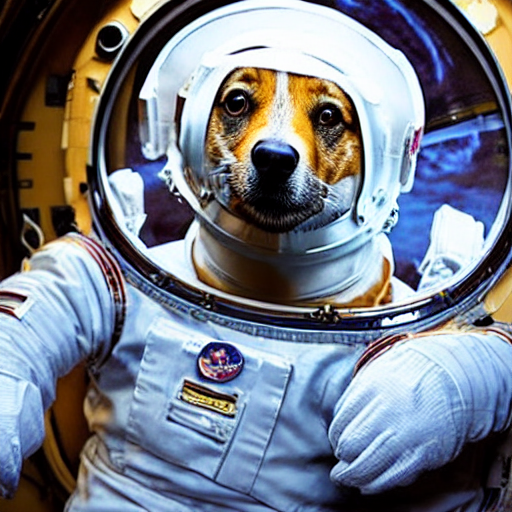

In [8]:
pipe(prompt).images[0]

Set a manual seed to always generate the same image

  0%|          | 0/50 [00:00<?, ?it/s]

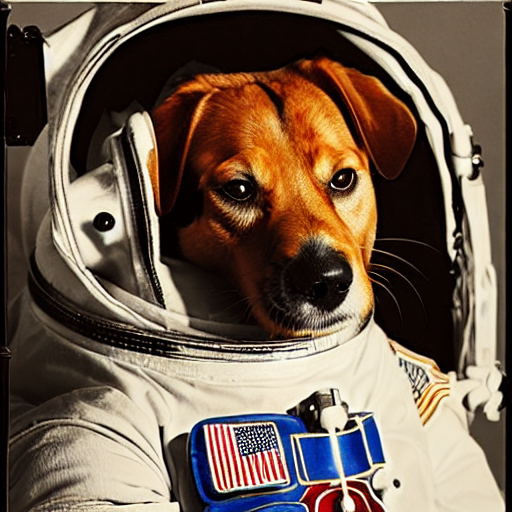

In [9]:
torch.manual_seed(1)
pipe(prompt).images[0]

- Stable diffusion is centered on a progressive denoising algorithm
- Images are created from random noise
- These models are known as diffusion models
- In the two cases above, it took 50 steps to create these images from random noise

Create an image in only 3 steps and observe the difference

  0%|          | 0/3 [00:00<?, ?it/s]

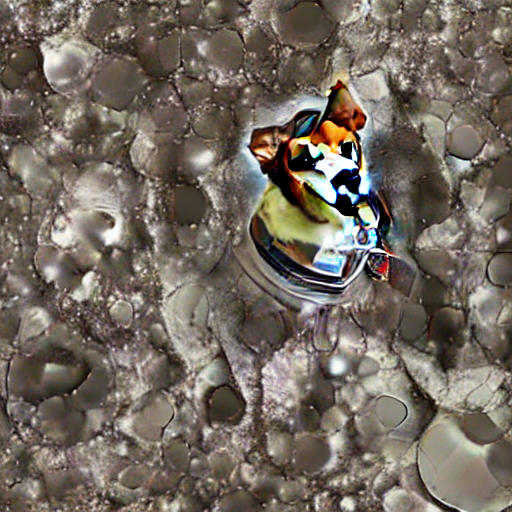

In [10]:
torch.manual_seed(1)
pipe(prompt, num_inference_steps=3).images[0]

Try 16 steps

  0%|          | 0/16 [00:00<?, ?it/s]

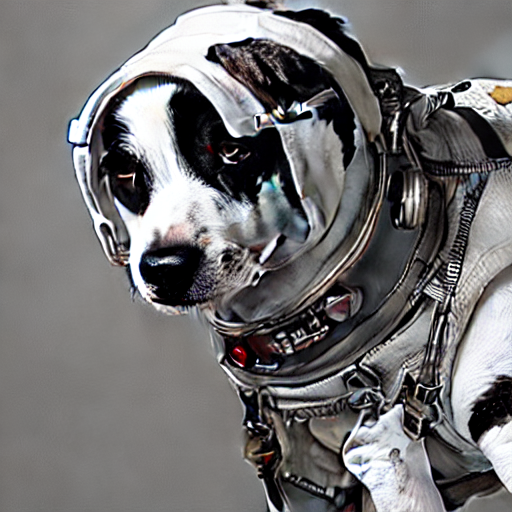

In [12]:
torch.manual_seed(1024)
pipe(prompt, num_inference_steps=16).images[0]

### Classifier-Free Guidance
- A method to increase the adherence of the output to the conditioning signal
- A larger guidance scale, `g`, intructs the model to create an image that is more representative of the prompt
- Try and bunch of guidenace scales

In [18]:
g = [1, 3, 7, 14]
prompts = [prompt] * len(g)
images = concat(pipe(prompts, guidance_scale=g).images for g in g)    

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

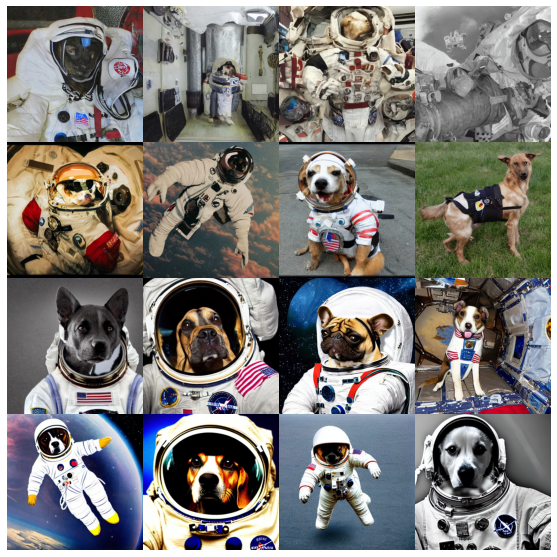

In [37]:
from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(10,10))
grid = ImageGrid(fig, 111, nrows_ncols=(4,4), axes_pad=0.0)
for ax, image in zip(grid, images):
    ax.imshow(image)
    ax.axis('off')

- With increasing guidance scale, `g`, the images are more like the prompt
- Bottom set of images have the highest `g` value
- The default `g` value is 7.5

### Negative prompt
- Use another prompt and scaling the difference between generations of that prompt and the conditioned generation

  0%|          | 0/50 [00:00<?, ?it/s]

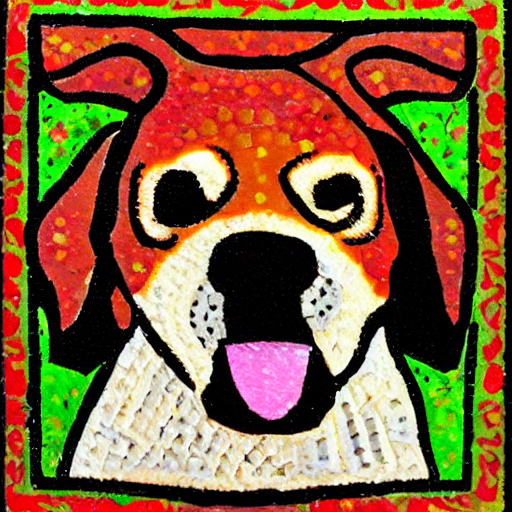

In [38]:
torch.manual_seed(1)
prompt = 'Dog in the style of mozaic art'
pipe(prompt).images[0]

  0%|          | 0/50 [00:00<?, ?it/s]

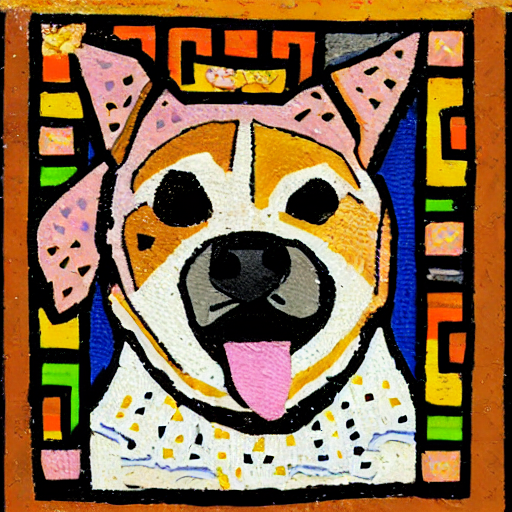

In [39]:
torch.manual_seed(1)
pipe(prompt, negative_prompt="red").images[0]

- Negative prompt produces an image more like the prompt
- Model produces an image by reducing the importance of the negative prompt

### Image to Image
- `StableDiffusionImg2ImgPipeline` is an image-to-image pipeline that when provided with an imitiatial image, noise is added to it and diffusion is performed from there
- Good performance with sketches

In [40]:
from diffusers import StableDiffusionImg2ImgPipeline
from fastdownload import FastDownload

Create new pipeline

In [41]:
pipe = StableDiffusionImg2ImgPipeline.from_pretrained(
    "CompVis/stable-diffusion-v1-4",
    revision="fp16",
    torch_dtype=torch.float16,
).to("cuda")

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

In [59]:
p = FastDownload().download('https://s3.amazonaws.com/moonup/production/uploads/1664665907257-noauth.png')

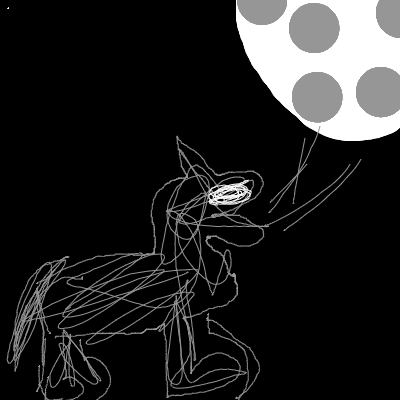

In [60]:
init_image = Image.open(p).convert("RGB")
init_image

In [61]:
prompt = "Wolf howling at the moon, photorealistic 4K"
images = pipe(prompt=prompt, num_images_per_prompt=3, init_image=init_image, strength=0.8, num_inference_steps=50).images

  0%|          | 0/40 [00:00<?, ?it/s]

In [62]:
images

[<PIL.Image.Image image mode=RGB size=384x384>,
 <PIL.Image.Image image mode=RGB size=384x384>,
 <PIL.Image.Image image mode=RGB size=384x384>]

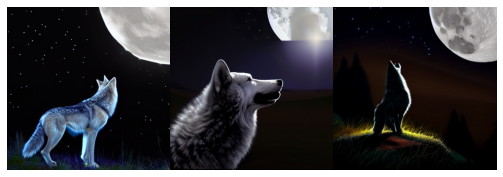

In [63]:
fig = plt.figure(figsize=(15,3))
grid = ImageGrid(fig, 111, nrows_ncols=(1,3), axes_pad=0.0)
for ax, image in zip(grid, images):
    ax.imshow(image)
    ax.axis('off')

- Image two looks the best
- Take image two and convert it to a Van Gogh like painting

In [64]:
init_images = images[1]
prompt = "Oil painting of wolf howling at the moon by Van Gogh"
images = pipe(prompt=prompt, num_images_per_prompt=3, init_image=init_image, strength=0.8, num_inference_steps=50).images

  0%|          | 0/40 [00:00<?, ?it/s]

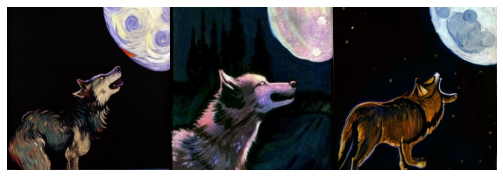

In [65]:
fig = plt.figure(figsize=(15,3))
grid = ImageGrid(fig, 111, nrows_ncols=(1,3), axes_pad=0.0)
for ax, image in zip(grid, images):
    ax.imshow(image)
    ax.axis('off')

### Latents and Callbacks
- Stable diffusions is based on a diffusion model called Latent Diffusion
- The stable diffusion pipeline can produce intermediate latents to a callback, which allows for visualisation of the denoisong process

In [96]:
pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", revision="fp16", torch_dtype=torch.float16).to("cuda")

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

In [102]:
vae = pipe.vae
images = []

def latents_callback(i, t, latents):
    latents = 1 / 0.18215 * latents
    image = vae.decode(latents).sample[0]
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.cpu().permute(1, 2, 0).numpy()
    images.extend(pipe.numpy_to_pil(image))

torch.manual_seed(1)
prompt = "a photograph of an dog as an astronaut"
final_image = pipe(prompt, callback=latents_callback, callback_steps=1).images[0]
images.append(final_image)

  0%|          | 0/50 [00:00<?, ?it/s]

In [104]:
len(images)

51

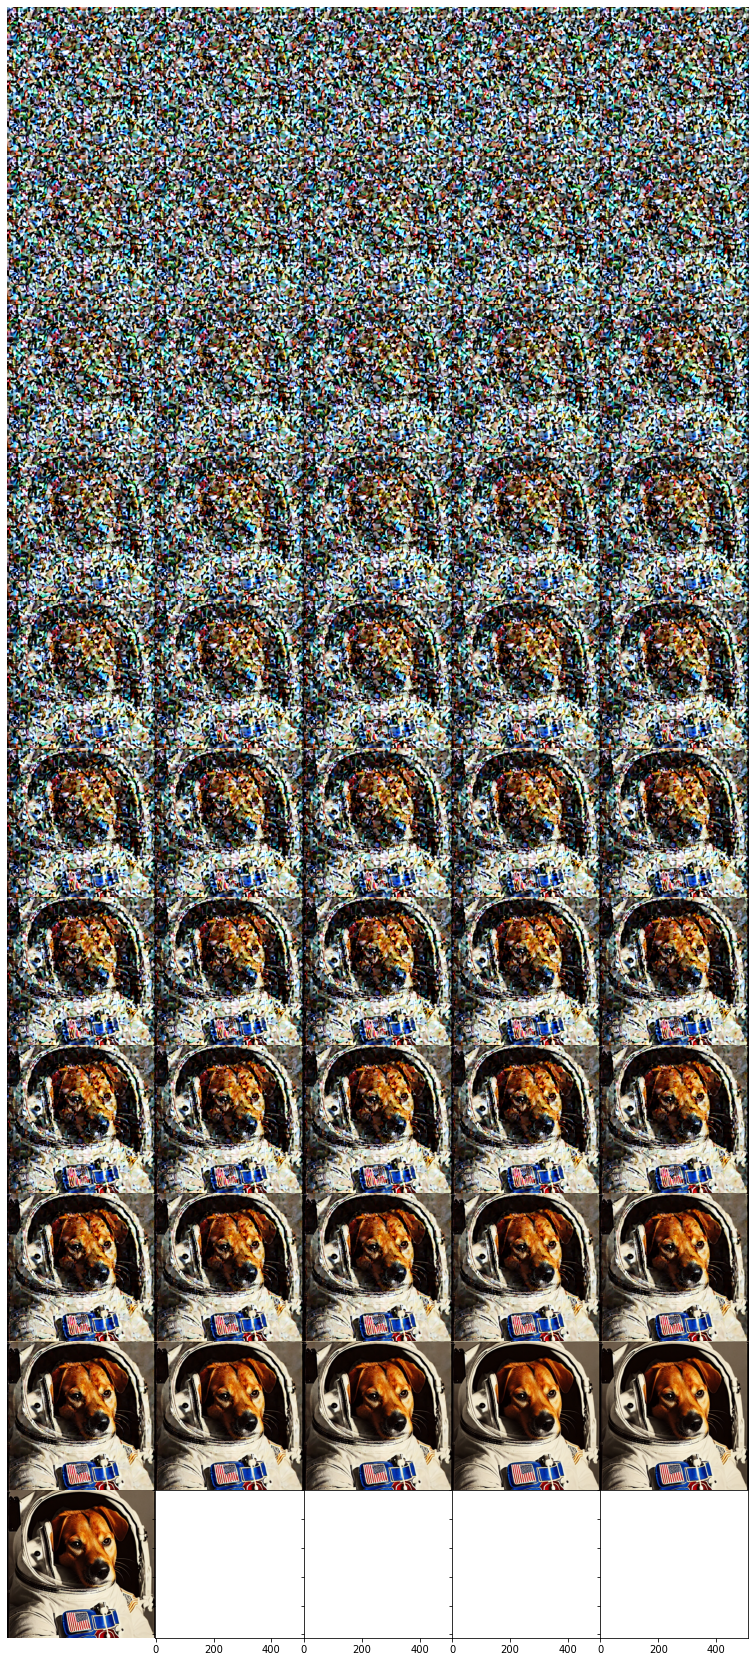

In [106]:
fig = plt.figure(figsize=(15,30))
grid = ImageGrid(fig, 111, nrows_ncols=(11,5), axes_pad=0.0)
for ax, image in zip(grid, images):
    ax.imshow(image)
    ax.axis('off')